Setting Up the Environment

In [1]:
# Install required packages for Bayesian Decision Network modeling
!pip install pyagrum pandas numpy

In [2]:
import pandas as pd

# Load the uploaded CSV file
file_path = "data/INVEST_clean.csv"
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Display the first few rows of the data to understand its structure
data.head()

,Date,Beta Monthly Leveraged,Beta Monthly Unleveraged,Beta Weekly Leveraged,ShareBeta,Price,Open,PE,Name,Debt/EquityIndustry,...,MarketRateOfReturn,RiskFreeRateOfReturn,PEMarket,PESector,EPS,PEYear,ROAE,ROE,Debt/Equity,ShareholdersEquity
0,2009-01-31,0.6654,0.5952,0.5796,0.5185,9718,10751,7.693,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,9.053,9.160,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
1,2009-02-28,0.7857,0.7028,0.5801,0.5189,8500,9900,5.403,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,8.205,8.715,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
2,2009-03-31,0.6346,0.5676,0.5384,0.4816,8509,8500,5.409,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,9.681,8.880,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
3,2009-04-30,0.6987,0.6250,0.5767,0.5159,10001,8850,6.357,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,9.834,9.457,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
4,2009-05-31,0.6445,0.5765,0.5821,0.5207,10355,9915,6.582,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,10.721,11.149,1610.8,6.6482,43.2376,37.3206,2.7983,2384550


Creating the basic structure for the BDN model, adding some example nodes and relationships to reflect a simplified investment decision framework.

In [3]:
import pyAgrum as gum

# Create a new Bayesian Network
bn = gum.BayesNet("INVEST_BDN")

# Define the nodes and their states
# These nodes are simplified and will later be extended based on the INVEST model logic
bn.add(gum.LabelizedVariable("MarketCondition", "General Market Condition", 2))  # States: Good, Bad
bn.add(gum.LabelizedVariable("SectorPerformance", "Sector-specific performance", 2))  # States: Positive, Negative
bn.add(gum.LabelizedVariable("SharePerformance", "Individual Share Performance", 3))  # States: High, Medium, Low

# Define relationships between the nodes (arcs)
# MarketCondition influences both SectorPerformance and SharePerformance
bn.addArc("MarketCondition", "SectorPerformance")
bn.addArc("SectorPerformance", "SharePerformance")

# Set up the Conditional Probability Tables (CPTs)
# CPT for MarketCondition (Prior probabilities)
bn.cpt("MarketCondition").fillWith([0.6, 0.4])  # 60% Good, 40% Bad

# CPT for SectorPerformance given MarketCondition
bn.cpt("SectorPerformance")[{"MarketCondition": 0}] = [0.7, 0.3]  # When Market is Good: 70% Positive, 30% Negative
bn.cpt("SectorPerformance")[{"MarketCondition": 1}] = [0.2, 0.8]  # When Market is Bad: 20% Positive, 80% Negative

# CPT for SharePerformance given SectorPerformance
bn.cpt("SharePerformance")[{"SectorPerformance": 0}] = [0.6, 0.3, 0.1]  # When Sector is Positive: High 60%, Medium 30%, Low 10%
bn.cpt("SharePerformance")[{"SectorPerformance": 1}] = [0.1, 0.3, 0.6]  # When Sector is Negative: High 10%, Medium 30%, Low 60%

# Display the created Bayesian Network structure
bn


(pyAgrum.BayesNet<double>@0x5a7075275910) BN{nodes: 3, arcs: 2, domainSize: 12, dim: 12}

Simulating Baseline Results Using the Model

Filtering the historical data for the General Industrials (JGIND) and Consumer Services (JCSEV) sectors.

In [4]:
# Define company names for General Industrials and Consumer Services sectors
general_industrials_companies = [
    "SUPER GROUP", "PPC", "NAMPAK", "MURRAY & ROBERTS", "KAP INDUSTRIAL",
    "INVICTA", "IMPERIAL", "BIDVEST GROUP", "BARLOWORLD", "AFRIMAT"
]

consumer_services_companies = [
    "WOOLWORTHS HDG", "TSOGO SUN", "TRUWORTHS INTL"
]

# Filter data based on the defined company names and the date range (2015-2018)
filtered_data_corrected = data[
    (data['Date'].dt.year >= 2015) & 
    (data['Date'].dt.year <= 2018) & 
    (data['Name'].isin(general_industrials_companies + consumer_services_companies))
]


Simulate Baseline Results Using the Model

In [5]:
# Using the available LazyPropagation for inference
inference = gum.LazyPropagation(bn)

# Prepare to store simulated probabilities and results
simulation_results_corrected = []

# Loop through the filtered dataset and perform inference for each month
for index, row in filtered_data_corrected.iterrows():
    # Set evidence for MarketCondition based on historical values
    if row["Date"].year == 2015:
        inference.setEvidence({"MarketCondition": 0})  # Good Market Condition
    elif row["Date"].year == 2018:
        inference.setEvidence({"MarketCondition": 1})  # Bad Market Condition
    
    # Run inference to get probabilities for SharePerformance
    inference.makeInference()
    share_performance_distribution = inference.posterior("SharePerformance").tolist()
    
    # Store results: Date, Company Name, MarketCondition, and predicted SharePerformance
    simulation_results_corrected.append({
        "Date": row["Date"],
        "Company": row["Name"],
        "MarketCondition": "Good" if row["Date"].year == 2015 else "Bad",
        "SharePerformance_High": share_performance_distribution[0],
        "SharePerformance_Medium": share_performance_distribution[1],
        "SharePerformance_Low": share_performance_distribution[2],
    })

# Convert results to a DataFrame for better visualization
simulation_df_corrected = pd.DataFrame(simulation_results_corrected)

# Display the corrected simulation results
print("BDN Simulation Results for Sector Performance", simulation_df_corrected)


BDN Simulation Results for Sector Performance           Date         Company MarketCondition  SharePerformance_High  \
0   2015-01-31     SUPER GROUP            Good                   0.45   
1   2015-02-28     SUPER GROUP            Good                   0.45   
2   2015-03-31     SUPER GROUP            Good                   0.45   
3   2015-04-30     SUPER GROUP            Good                   0.45   
4   2015-05-31     SUPER GROUP            Good                   0.45   
..         ...             ...             ...                    ...   
619 2018-08-31  TRUWORTHS INTL             Bad                   0.20   
620 2018-09-30  TRUWORTHS INTL             Bad                   0.20   
621 2018-10-31  TRUWORTHS INTL             Bad                   0.20   
622 2018-11-30  TRUWORTHS INTL             Bad                   0.20   
623 2018-12-31  TRUWORTHS INTL             Bad                   0.20   

     SharePerformance_Medium  SharePerformance_Low  
0                       

We will now proceed to calculate key investment metrics, such as:

Cumulative Return (CR).
Average Annual Return (AAR).
Total Return (TR).
Sharpe Ratio (SR).

In [6]:
import numpy as np

# Group the data by company and calculate metrics
performance_metrics = []

# Calculate the risk-free rate of return for Sharpe Ratio
risk_free_rate = 0.02  # Assuming a constant 2% annual risk-free rate

# Iterate over each company in the filtered dataset
for company, company_data in filtered_data_corrected.groupby("Name"):
    # Sort by date to ensure time series consistency
    company_data = company_data.sort_values(by="Date")
    
    # Calculate Cumulative Return (CR)
    initial_price = company_data.iloc[0]["Price"]
    ending_price = company_data.iloc[-1]["Price"]
    cumulative_return = (ending_price / initial_price) - 1
    
    # Calculate Average Annual Return (AAR)
    annual_returns = (company_data["Price"].pct_change() + 1).dropna()  # Calculate percentage change for each period
    average_annual_return = annual_returns.mean()
    
    # Calculate Total Return (TR)
    total_return = (ending_price - initial_price) / initial_price
    
    # Calculate Sharpe Ratio (SR)
    sharpe_ratio = (average_annual_return - risk_free_rate) / annual_returns.std()
    
    # Store the calculated metrics
    performance_metrics.append({
        "Company": company,
        "Cumulative Return (CR)": cumulative_return,
        "Average Annual Return (AAR)": average_annual_return,
        "Total Return (TR)": total_return,
        "Sharpe Ratio (SR)": sharpe_ratio
    })

# Convert metrics to DataFrame for better visualization
performance_df = pd.DataFrame(performance_metrics)

# Display the performance metrics table
print("Company Performance Metrics (2015-2018)", performance_df)


Company Performance Metrics (2015-2018)              Company  Cumulative Return (CR)  Average Annual Return (AAR)  \
0            AFRIMAT                0.676647                     1.014218   
1         BARLOWORLD                0.304850                     1.009258   
2      BIDVEST GROUP               -0.359736                     1.002142   
3           IMPERIAL               -0.670191                     0.987709   
4            INVICTA               -0.542346                     0.988112   
5     KAP INDUSTRIAL                0.599606                     1.011935   
6   MURRAY & ROBERTS               -0.265379                     1.001499   
7             NAMPAK               -0.674959                     0.980666   
8                PPC               -0.724299                     0.981587   
9        SUPER GROUP               -0.008762                     1.001959   
10    TRUWORTHS INTL                0.087654                     1.004832   
11         TSOGO SUN               -

Share-Level Analysis of Contributions to AAR
Here we analyze each share's contribution to the Average Annual Return (AAR) for the overall portfolio. This will help us understand which shares positively or negatively influenced the portfolio's performance

In [7]:
# Calculate annual returns for each company in the filtered dataset
annual_return_data = []

# Group by company and year to calculate the annual returns
for company, company_data in filtered_data_corrected.groupby("Name"):
    # Calculate the yearly price change
    company_data["Year"] = company_data["Date"].dt.year
    yearly_price_change = company_data.groupby("Year")["Price"].last().pct_change().dropna()  # Calculate annual returns

    # Store the yearly return for each company
    for year, annual_return in yearly_price_change.items():
        annual_return_data.append({
            "Company": company,
            "Year": year,
            "Annual Return": annual_return
        })

# Convert to DataFrame for analysis
annual_return_df = pd.DataFrame(annual_return_data)

# Display the annual return data for each share
print("Annual Return Data for Shares (2015-2018)", annual_return_df)


Annual Return Data for Shares (2015-2018)              Company  Year  Annual Return
0            AFRIMAT  2016      -0.043390
1            AFRIMAT  2017       0.052445
2            AFRIMAT  2018      -0.057239
3         BARLOWORLD  2016       0.902533
4         BARLOWORLD  2017       0.353350
5         BARLOWORLD  2018      -0.278391
6      BIDVEST GROUP  2016      -0.447762
7      BIDVEST GROUP  2017       0.203255
8      BIDVEST GROUP  2018      -0.051538
9           IMPERIAL  2016       0.528485
10          IMPERIAL  2017       0.436856
11          IMPERIAL  2018      -0.740597
12           INVICTA  2016       0.529726
13           INVICTA  2017      -0.256914
14           INVICTA  2018      -0.318315
15    KAP INDUSTRIAL  2016       0.084058
16    KAP INDUSTRIAL  2017       0.062834
17    KAP INDUSTRIAL  2018       0.020126
18  MURRAY & ROBERTS  2016       0.440000
19  MURRAY & ROBERTS  2017       0.051215
20  MURRAY & ROBERTS  2018       0.193229
21            NAMPAK  2016      -0

Calculate Each Share’s Contribution to AAR
We'll calculate the contribution of each share to the overall Average Annual Return (AAR) for the portfolio by:
1- Weighting each share’s return based on its proportion in the portfolio (assuming equal weighting initially).
2- Summing the weighted returns to get the total AAR contribution for each share.

In [8]:
# Calculate the share contributions to AAR
# Assuming an equal weighting of shares in the portfolio initially
total_shares = annual_return_df["Company"].nunique()

# Calculate the contribution of each share to the overall AAR
annual_return_df["Contribution to AAR"] = annual_return_df["Annual Return"] / total_shares

# Group by company to get the total contribution of each share over the period
share_contributions_df = annual_return_df.groupby("Company")["Contribution to AAR"].sum().reset_index()

# Rename the columns for clarity
share_contributions_df.columns = ["Company", "Total Contribution to AAR"]

# Display the contributions data
print("Share Contributions to Average Annual Return (AAR)", share_contributions_df)


Share Contributions to Average Annual Return (AAR)              Company  Total Contribution to AAR
0            AFRIMAT                  -0.003706
1         BARLOWORLD                   0.075192
2      BIDVEST GROUP                  -0.022773
3           IMPERIAL                   0.017288
4            INVICTA                  -0.003500
5     KAP INDUSTRIAL                   0.012848
6   MURRAY & ROBERTS                   0.052650
7             NAMPAK                  -0.040409
8                PPC                  -0.041079
9        SUPER GROUP                  -0.006970
10    TRUWORTHS INTL                  -0.000585
11         TSOGO SUN                  -0.007475
12    WOOLWORTHS HDG                  -0.040596


In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


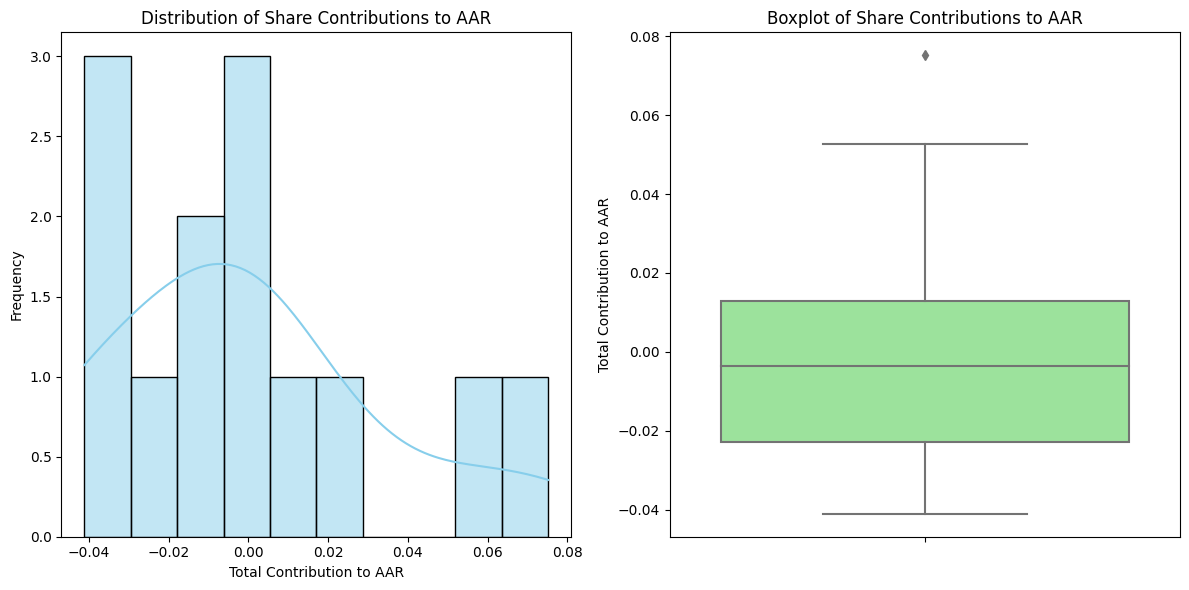

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
plt.figure(figsize=(12, 6))

# Histogram of Share Contributions to AAR
plt.subplot(1, 2, 1)
sns.histplot(share_contributions_df["Total Contribution to AAR"], bins=10, kde=True, color="skyblue")
plt.title("Distribution of Share Contributions to AAR")
plt.xlabel("Total Contribution to AAR")
plt.ylabel("Frequency")

# Boxplot for Share Contributions to AAR
plt.subplot(1, 2, 2)
sns.boxplot(data=share_contributions_df, y="Total Contribution to AAR", color="lightgreen")
plt.title("Boxplot of Share Contributions to AAR")

# Show the plots
plt.tight_layout()
plt.show()
